In [1]:
!pip3 install open3d

In [2]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import math

In [3]:
pcd = o3d.io.read_point_cloud("/Users/daraandreeva/Downloads/pointclouds/scene_dense_sber.ply")

In [4]:
point_cloud_in_numpy = np.asarray(pcd.points)
point_cloud_in_numpy 

array([[-3.81545782, -0.34077999,  1.90094817],
       [-3.81499481, -0.34146237,  1.90027225],
       [-3.81462741, -0.34079236,  1.89844096],
       ...,
       [-4.59054852,  0.53128552,  1.52766979],
       [-4.58382034,  0.53391516,  1.59634221],
       [-4.49518633,  0.53137571,  2.00885963]])

# NDT

Был вариант, для инициализации А использовать VoxelGrid, но я так и не придумала, как вытащить оттуда соотношение кубик-массив точек в нем, поэтому делим каждую координату нацело на s, получаем координаты кубика для каждой точки.

In [19]:
s = 0.5
te = 0.01
A = point_cloud_in_numpy // s # разбиение PCD на кубики
Q = np.array([0, 0, 0]) # плоские NDT ячейки
Q_points = []
P = [] # остальные ячейки

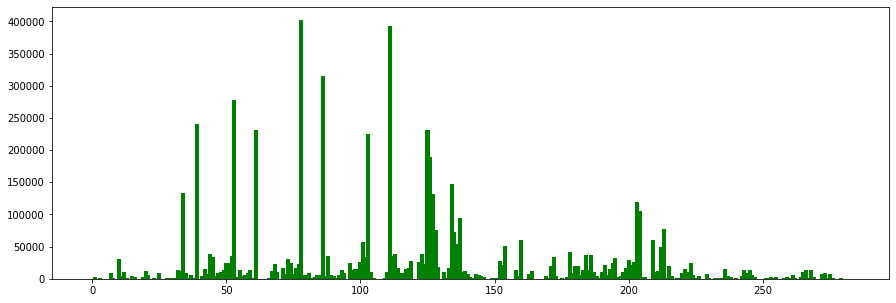

In [6]:
unique,counts=np.unique(A,axis=0, return_counts=True)
plt.figure(figsize=(15,5))
plt.bar(range(0, len(counts)), counts, width=1.5, color='g')
plt.show()

In [22]:
mu = []
for ind, i in enumerate(unique):
    this_cell = np.array(point_cloud_in_numpy[np.where(np.prod(A == i, axis = -1))])
    if (len(this_cell) <= 3):
        P.append(this_cell)
        continue
    mu.append(np.mean(this_cell))
    cov = np.cov(np.array(this_cell).T)
    #print("cov = ", cov)
    w, v = np.linalg.eig(cov)
    w = np.sort(w)
    #print("values = ", w)
    if (abs(w[0] / w[1]) <= te):
        Q = np.vstack((Q, i))
        Q_points.append(list(this_cell))
    else:
        P.append(list(this_cell))
Q = Q[1:,]

[[  0.   0.   0.]
 [-14.   0.   3.]
 [-13.   0.   4.]
 [-11.   0.   4.]
 [-11.   1.   3.]
 [-10.  -1.   1.]
 [-10.   0.   4.]
 [-10.   1.   1.]
 [-10.   1.   3.]
 [ -9.   0.   4.]
 [ -9.   1.   0.]
 [ -9.   1.   2.]
 [ -9.   1.   3.]
 [ -8.  -1.  -2.]
 [ -8.  -1.   2.]
 [ -8.  -1.   3.]
 [ -8.   0.   4.]
 [ -8.   1.   2.]
 [ -8.   1.   3.]
 [ -7.  -1.  -2.]
 [ -7.  -1.  -1.]
 [ -7.  -1.   0.]
 [ -7.  -1.   1.]
 [ -7.   0.  -1.]
 [ -7.   0.   0.]
 [ -7.   0.   4.]
 [ -7.   1.  -3.]
 [ -7.   1.  -2.]
 [ -7.   1.  -1.]
 [ -7.   1.   0.]
 [ -7.   1.   1.]
 [ -7.   1.   2.]
 [ -7.   1.   3.]
 [ -6.  -1.  -2.]
 [ -6.   0.   3.]
 [ -6.   1.  -2.]
 [ -6.   1.   1.]
 [ -6.   1.   2.]
 [ -6.   1.   3.]
 [ -5.  -1.  -2.]
 [ -5.   0.  -5.]
 [ -5.   0.   1.]
 [ -5.   1.  -3.]
 [ -5.   1.  -2.]
 [ -4.   0.  -6.]
 [ -4.   0.  -3.]
 [ -4.   1.  -3.]
 [ -4.   1.  -2.]
 [ -3.   0.  -3.]
 [ -3.   1.  -3.]
 [ -3.   1.  -2.]
 [ -2.  -1.  -4.]
 [ -2.  -1.  -2.]
 [ -2.   0.  -3.]
 [ -2.   0.   1.]
 [ -2.   1

# RANSAC

In [ ]:
k_max = 50
nu = 0.95
delta_d = 0.08
n = 0
delta_theta = math.cos(math.pi / 12)
k = 0
Psi = np.zeros(len(Q), dtype=np.bool)
Psi_size = 0
Psi_points = []

In [ ]:
# пытаемся в линейную регрессию, чтобы найти нормаль
def find_normal(surf):
    R = np.transpose(np.vstack((surf[:, 1], surf[:, 2], np.ones(np.shape(surf[:, 2])))))
    a = np.linalg.inv(np.transpose(R) @ R) @ np.transpose(R) @ surf[:, 0]
    if a[0] >= 1e6 or a[1] >= 1e6:
        R = np.transpose(np.vstack((surf[:, 0], surf[:, 2], np.ones(np.shape(surf[:, 2])))))
        a = np.linalg.inv(np.transpose(R) @ R) @ np.transpose(R) @ surf[:, 1]
        return np.array([a[0] * (-1), 1, a[1] * (-1)])
    return np.array([1, a[0] * (-1), a[1] * (-1)])

In [29]:
print(np.shape(np.array(P[1])))

(4, 3)


In [ ]:
k = 1
while k < k_max:
    c = np.random.choice(range(0, len(Q)))
    cell = Q[c]
    points = Q_points[c]
    gk = np.var(points)
    nk = find_normal(points)
    Ik = np.zeros(len(Q), dtype=np.bool)
    Ik_points = []
    for i, v in enumerate(Q):
        g_i = np.var(Q_points[i])
        n_i = find_normal(Q_points[i])
        d_i = np.linalg.norm((g_i - gk) * n)
        theta_i = np.dot(nk, n_i) / (np.linalg.norm(nk) * np.linalg.norm(n_i))
        if (d_i < delta_d and theta_i < delta_theta):
            Ik[i] = 1
            Ik_points += Q_points[i]
    if sum(Ik) > len(Psi):
        Psi = Ik
        Psi_points = Ik_points
        Psi_size = sum(Ik)
        n = nk
        g = gk
        Pn = Psi_size / len(Q)
        k_max = math.ceil(math.log(1 - nu) / math.log(1 - Pn))
    k = k + 1
for i in P
    